In [2]:
!pip install seaborn


In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn instead of using style directly

sns.set()  # Set seaborn default style globally
plt.rcParams["figure.figsize"] = (20, 5)


In [ ]:
# Replace the filename with your dataset's name if it is different
df = pd.read_csv('customer_transactions.csv')

# Convert date column to datetime (update column name if needed!)
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], errors='coerce')

# Rename relevant columns to standardized names for RFM processing
df.rename(columns={
    'Customer_ID': 'id',
    'Sales_Amount': 'monetary',
    'Quantity_Sold': 'units',
    'Sale_Date': 'date',
    'Region': 'country'
}, inplace=True)


# Drop any invalid dates (missing or conversion errors)
#cleaning
df = df.dropna(subset=['date'])

# Preview
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1000 non-null   int64         
 1   date              1000 non-null   datetime64[ns]
 2   Customer_Name     1000 non-null   object        
 3   country           1000 non-null   object        
 4   monetary          1000 non-null   int64         
 5   units             1000 non-null   int64         
 6   Product_Category  1000 non-null   object        
 7   Unit_Cost         1000 non-null   float64       
 8   Unit_Price        1000 non-null   float64       
 9   Customer_Type     1000 non-null   object        
 10  Discount          1000 non-null   float64       
 11  Payment_Method    1000 non-null   object        
 12  Sales_Channel     1000 non-null   object        
 13  Segment           1000 non-null   object        
dtypes: datetime64[ns](1), flo

In [5]:
# Use the last 365 days of sales for segmentation
period = 365
date_N_days_ago = df['date'].max() - timedelta(days=period)
df = df[df['date'] > date_N_days_ago].reset_index(drop=True)

# Create a unique customer id by combining country and Customer_ID (note renamed to 'id')
df['id+'] = df['country'].astype(str) + df['id'].astype(str)

# Reference date is last sale + 1 day
NOW = df['date'].max() + timedelta(days=1)

# Calculate days since last purchase
df['days_since_purchase'] = df['date'].apply(lambda x: (NOW - x).days)


In [6]:
# Aggregation dictionary for RFM metrics
agg_funcs = {
    'days_since_purchase': 'min',  # Recency: most recent purchase (lowest days since last purchase)
    'date': 'count'                # Frequency: number of purchases
}

# Group by customer id, unique id+, and country
rfm = df.groupby(['id', 'id+', 'country']).agg(agg_funcs).reset_index()

# Rename columns for clarity
rfm.rename(columns={
    'days_since_purchase': 'recency',
    'date': 'frequency'
}, inplace=True)

# Calculate monetary per customer by summing monetary values grouped by 'id+'
monetary = df.groupby('id+')['monetary'].sum()

# Merge monetary data into RFM dataframe
rfm = rfm.merge(monetary, left_on='id+', right_index=True)

# Preview the RFM data
print(rfm.head())


    id       id+ country  recency  frequency  monetary
0  636   East636    East      365          1      4499
1  637  North637   North      364          1      3464
2  638  North638   North      363          1      3122
3  639  North639   North      362          1      3471
4  640  South640   South      361          1      2930


In [7]:
# Drop 'id+' column since it's no longer needed
rfm.drop(columns=['id+'], inplace=True)

# Compute quintiles for R, F, and M
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()

# Define scoring functions
def r_score(x):
    if x <= quintiles['recency'][0.2]:
        return 5
    elif x <= quintiles['recency'][0.4]:
        return 4
    elif x <= quintiles['recency'][0.6]:
        return 3
    elif x <= quintiles['recency'][0.8]:
        return 2
    else:
        return 1

def fm_score(x, col):
    if x <= quintiles[col][0.2]:
        return 1
    elif x <= quintiles[col][0.4]:
        return 2
    elif x <= quintiles[col][0.6]:
        return 3
    elif x <= quintiles[col][0.8]:
        return 4
    else:
        return 5

# Apply scoring to create r, f, m columns
rfm['r'] = rfm['recency'].apply(r_score)
rfm['f'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['m'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

# Create combined RFM score string
rfm['rfm_score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)

print(rfm.head())


    id country  recency  frequency  monetary  r  f  m rfm_score
0  636    East      365          1      4499  1  1  5       115
1  637   North      364          1      3464  1  1  4       114
2  638   North      363          1      3122  1  1  4       114
3  639   North      362          1      3471  1  1  4       114
4  640   South      361          1      2930  1  1  3       113


In [8]:
import math

# Calculate combined FM score (for simplified segmentation)
rfm['fm'] = ((rfm['f'] + rfm['m']) / 2).apply(math.trunc)

# Segment map based on R and FM scores
segment_map = {
    r'22': 'hibernating',
    r'[1-2][1-2]': 'lost',
    r'15': "can't lose",
    r'[1-2][3-5]': 'at risk',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'55': 'champions',
    r'[3-5][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists'
}

# Combine r and fm as strings and use regex replacement for mapping
rfm['segment'] = (rfm['r'].astype(str) + rfm['fm'].astype(str)).replace(segment_map, regex=True)

print(rfm[['id', 'country', 'recency', 'frequency', 'monetary', 'r', 'f', 'm', 'rfm_score', 'fm', 'segment']].head())


    id country  recency  frequency  monetary  r  f  m rfm_score  fm  segment
0  636    East      365          1      4499  1  1  5       115   3  at risk
1  637   North      364          1      3464  1  1  4       114   2     lost
2  638   North      363          1      3122  1  1  4       114   2     lost
3  639   North      362          1      3471  1  1  4       114   2     lost
4  640   South      361          1      2930  1  1  3       113   2     lost


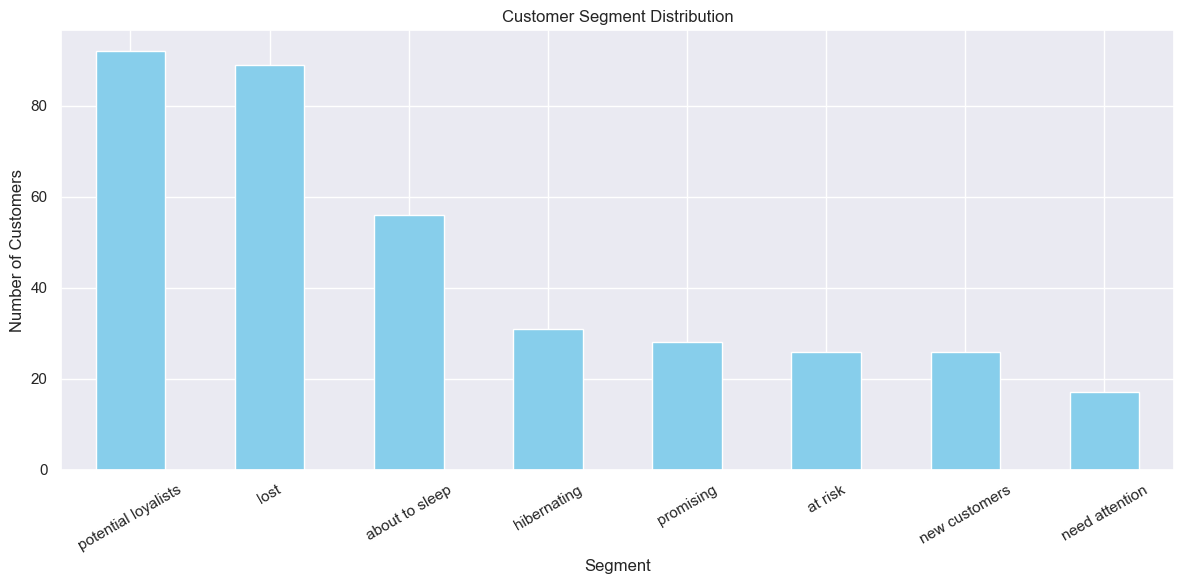

In [9]:
import matplotlib.pyplot as plt

segment_counts = rfm['segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', color='skyblue')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


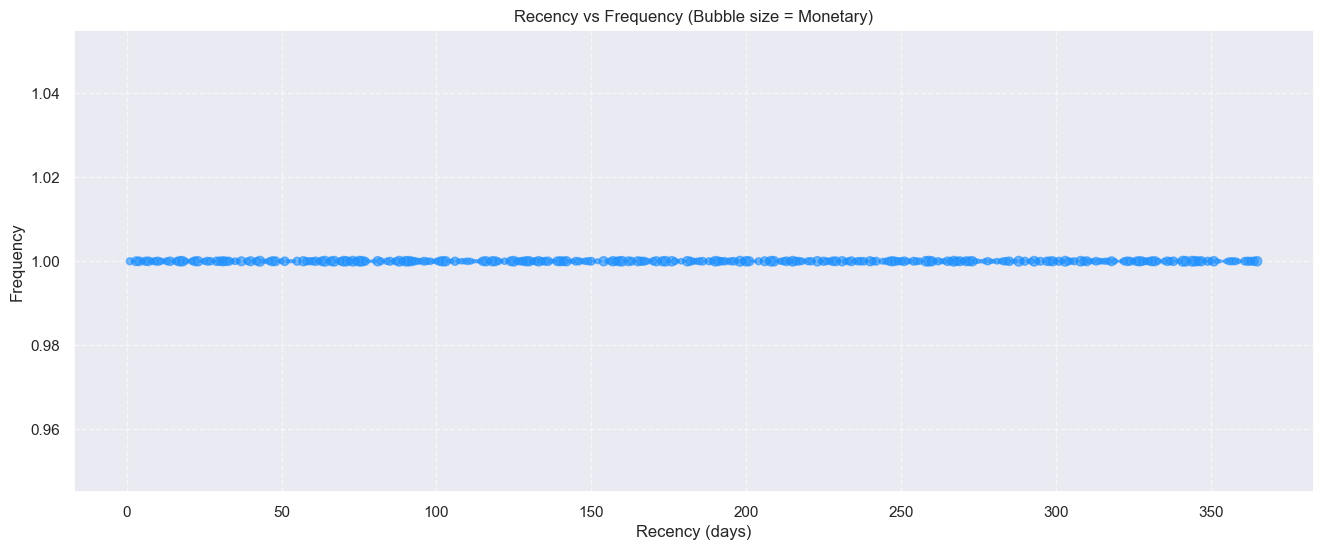

In [10]:
plt.figure(figsize=(16, 6))
plt.scatter(rfm['recency'], rfm['frequency'], s=rfm['monetary']*0.01, alpha=0.6, c='dodgerblue')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency (Bubble size = Monetary)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [11]:
rfm.to_csv('rfm_segments_output.csv', index=False)


In [12]:
segment_summary = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum'],
    'id': 'count'
}).rename(columns={'id': 'count'})

print(segment_summary)


                        recency frequency     monetary         count
                           mean      mean         mean     sum count
segment                                                             
about to sleep       183.357143       1.0  1927.214286  107924    56
at risk              298.192308       1.0  4518.615385  117484    26
hibernating          251.193548       1.0  3108.451613   96362    31
lost                 305.224719       1.0  1755.325843  156224    89
need attention       181.823529       1.0  4515.470588   76763    17
new customers         35.615385       1.0   881.730769   22925    26
potential loyalists   73.108696       1.0  3561.565217  327664    92
promising            109.964286       1.0  1078.321429   30193    28


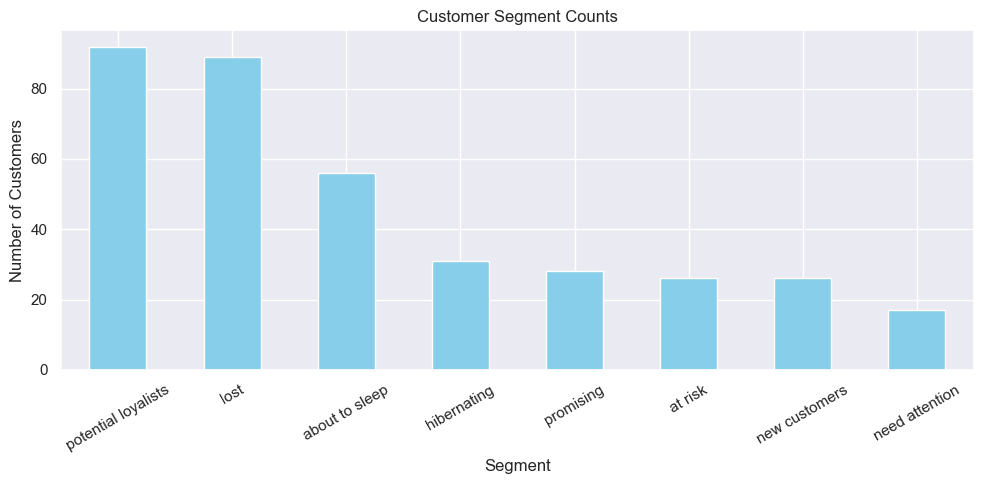

In [13]:
import matplotlib.pyplot as plt

rfm['segment'].value_counts().plot(kind='bar', color='skyblue', figsize=(10,5))
plt.title('Customer Segment Counts')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


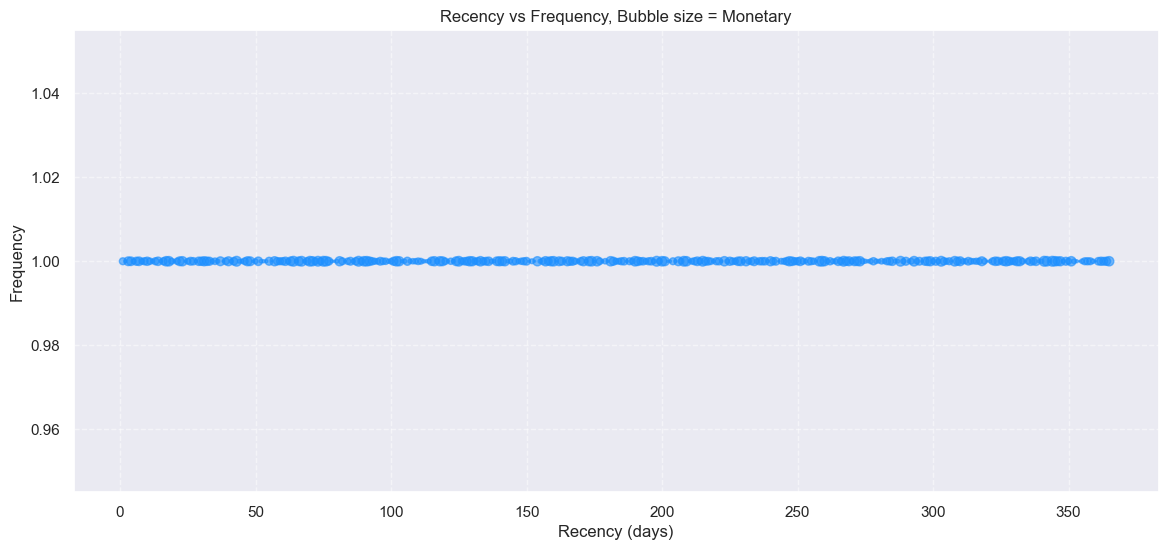

In [14]:
plt.figure(figsize=(14, 6))
plt.scatter(rfm['recency'], rfm['frequency'], s=rfm['monetary']*0.01, c='dodgerblue', alpha=0.6)
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency, Bubble size = Monetary')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [15]:
recommendations = {
    "champions": "Reward and retain, ask for reviews.",
    "loyal customers": "Upsell and loyalty programs.",
    "potential loyalists": "Nurture with engagement and deals.",
    "new customers": "Welcome and onboard.",
    "promising": "Send targeted offers.",
    "need attention": "Win-back campaigns.",
    "about to sleep": "Reactivation offers.",
    "at risk": "Deep discounts or reminders.",
    "hibernating": "Occasional reminders.",
    "can't lose": "Priority win-back with extra value.",
    "lost": "Disengaged, minimal effort."
}
for segment, advice in recommendations.items():
    print(f"{segment.title()}: {advice}")


Champions: Reward and retain, ask for reviews.
Loyal Customers: Upsell and loyalty programs.
Potential Loyalists: Nurture with engagement and deals.
New Customers: Welcome and onboard.
Promising: Send targeted offers.
Need Attention: Win-back campaigns.
About To Sleep: Reactivation offers.
At Risk: Deep discounts or reminders.
Hibernating: Occasional reminders.
Can'T Lose: Priority win-back with extra value.
Lost: Disengaged, minimal effort.


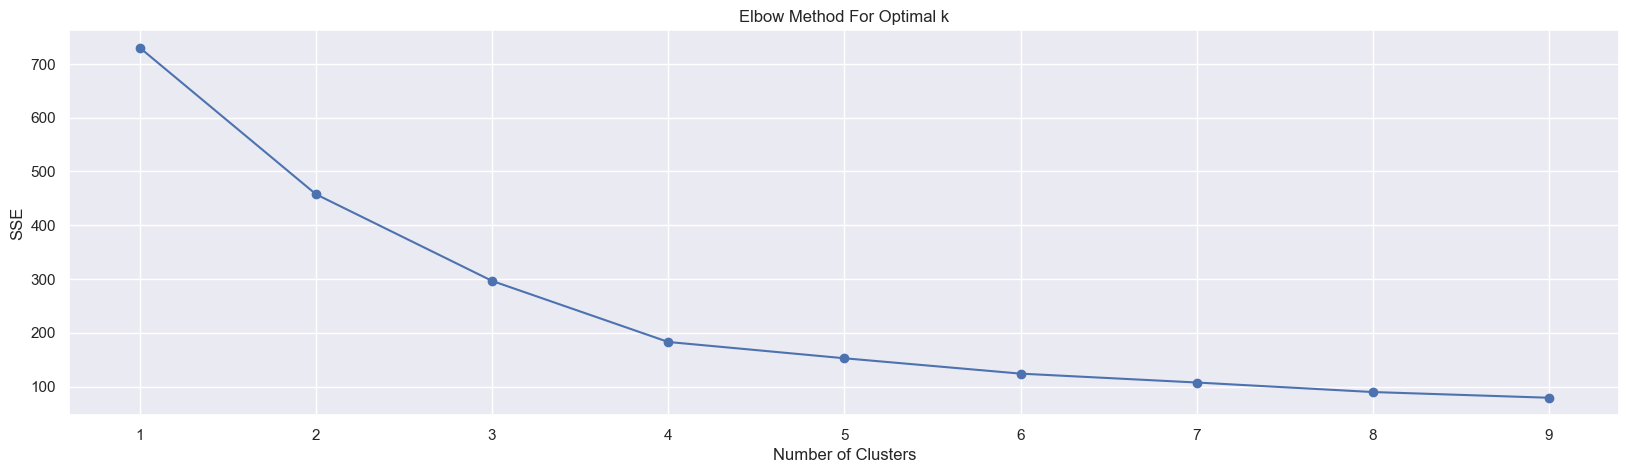

2025-09-23 08:55:58.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 08:55:58.717 
  command:

    streamlit run C:\Users\thowt\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-23 08:55:58.718 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import streamlit as st
import matplotlib.pyplot as plt

# Scale RFM features
#normalization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency','frequency','monetary']])

# Determine optimal number of clusters (Elbow Method)
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

# Fit final KMeans with chosen k (e.g., 4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

st.write(rfm.groupby('cluster')[['recency','frequency','monetary']].mean())


In [22]:
rfm.to_csv('rfm_segments_output.csv', index=False)
segment_summary.to_csv('rfm_segment_summary.csv')
